In [151]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

In [152]:
with open('data/names.txt', 'r') as f:
    names_list = f.read().splitlines()

In [153]:
# Get all characters in the name_list
all_chars = sorted(list(set(''.join(names_list))))

# Encoding alphabet using numbering 
# Also using the char '.' to replace the <S> and <E>, the '.' is denoted as 0
stoi = {s:i+1 for i, s in enumerate(all_chars)}
stoi['.'] = 0

# Decoding
itos = {i:s for s, i in stoi.items()}

# Get the number of all_chars list
char_num = len(stoi)

In [154]:
def built_dataset(text, ws, show=False, shuffle=False):
    """ Build the dataset
    text: the raw text
    ws: the number of token for predicting next char
    show: whether show samples in the dataset, default to fault
    """
    X, Y = [], []
    
    if shuffle:
    # Shuffle the x and y
        random.seed(345567)
        random.shuffle(text)

    for t in text:
        # Clean up the window for the next name
        content = [0] * ws

        for c in t + '.':
            X.append(content)
            Y.append(stoi[c])
            content = content[1:] + [stoi[c]]
            if show:
                print(''.join(itos[i] for i in content), '--->', c)

    return torch.tensor(X), torch.tensor(Y)

In [155]:
def split_dataset(x, y, tr_rate=0.8, va_rate=0.1):
    assert len(x) == len(y), "The length of two given arrays are not compatiable "

    tr_num = int(tr_rate * len(x))
    va_num = int((tr_rate + va_rate) * len(x))
    
    return x[:tr_num], y[:tr_num], x[tr_num:va_num], y[tr_num:va_num], x[va_num:], y[va_num:]

In [156]:
# The window size = 3, then it use 3 tokens to predict the next chars
window_size = 3
xs, ys = built_dataset(text=names_list, ws=window_size, shuffle=True)

In [157]:
x_tr, y_tr, x_va, y_va, x_te, y_te = split_dataset(xs, ys)

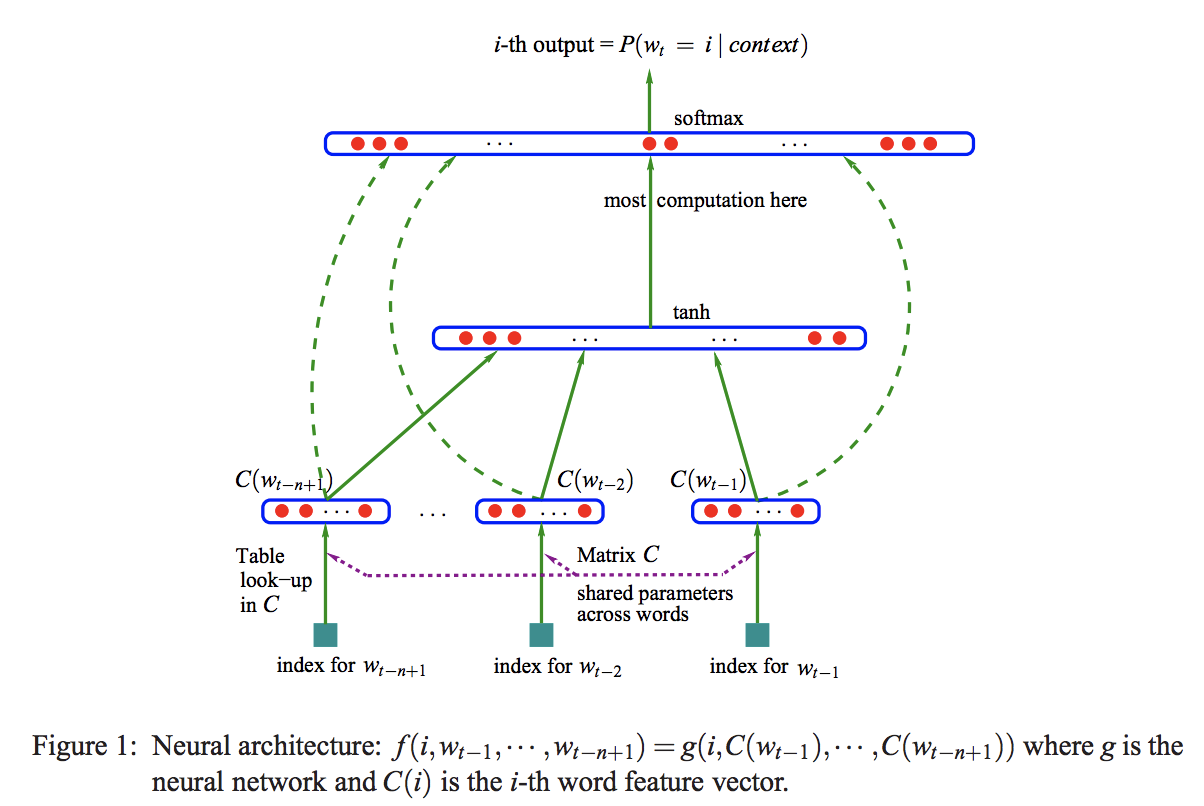

In [158]:
display.Image('imgs/mlp_language_model.png') # Show the network structure

In [159]:
# Create the look up table, suppose the embedding space is n-dimensional
# then the size of the lookup table is [27, n] (n components for 27 inputs)
emb_dim = 10
lookup = torch.randn((char_num, emb_dim))

In [160]:
# Look up the table using the tensor xs to represent xs by the embedding vectors
# For each samples, there are 'windows_size' chars, each chars are represented by a nd vector
# Thus for each sample, the dimension is windows_size x n
# There are totally 228146 samples in the dataset, then the shape of the tensor is 228146 x 3 x 2
emb = lookup[xs]
emb.shape

torch.Size([228146, 3, 10])

In [172]:
g = torch.Generator().manual_seed(84822933)
kaiming_init = (5/3) / ((emb_dim * window_size) ** 0.5) # Kaiming_init value
neuron_num = 200

# Initalize parameters
# b2 will be initalized by all 0 to eliminate randomness
# W2 will be set to a small initial number to avoid extrem values in the weight matrix
# b1 is set to 0, and W1 is multiple by 0.1 to shrink the range of the value distribution
W1 = torch.randn(window_size * emb_dim, neuron_num, generator=g) * kaiming_init
# b1 = torch.randn(neuron_num,                        generator=g) * 0.01
W2 = torch.randn(neuron_num, char_num,              generator=g) * 0.01
b2 = torch.randn(char_num,                          generator=g) * 0

# Batch noramlize parameters
bngain = torch.ones((1, neuron_num))
bnbias = torch.zeros((1, neuron_num))
bnmean_running = torch.zeros((1, neuron_num))
bnstd_running = torch.ones((1, neuron_num))

params = [lookup, W1, W2, b2, bngain, bnbias]

# Set all parameters to be trainable
for p in params:
    p.requires_grad = True

# Sum up the number of parameters
print("Total number of parameters: {}".format(sum(p.nelement() for p in params)))

Total number of parameters: 12097


##### Batch normalization is to normalize the batch to avoid variance shift in each batch for a better training performance, during the training, we promise the shape of the batch normalization by shift and scale?

In [178]:
# Train the network
lr = 0.015
epoch = 100000
batch_size = 64
stepi, lossi = [], []

for k in range(epoch):
    # Training batch construct
    batch_idx = torch.randint(0, x_tr.shape[0], (batch_size,))  # Get batch index 
    batch_emb = lookup[x_tr[batch_idx]]    # Only use select samples as a batch for training
    target = y_tr[batch_idx]               # The corresponding targets for training

    # forward
    # The bias b1 is useless, since the b1 will be then substract exactly in the normalization process
    h_preact = batch_emb.view(batch_emb.shape[0], -1) @ W1 

    # Get rid of the dependency on batch input requirement and allow a single input for later deployment
    bnmeani = h_preact.mean(0, keepdim=True)
    bnstdi = h_preact.std(0, keepdim=True)
    h_preact = bngain * (h_preact - bnmeani) / bnstdi + bnbias # Batch normalization
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    # Non-linearity layer
    h = torch.tanh(h_preact)

    # Output layer
    logits = h @ W2 + b2

    # loss 
    loss = F.cross_entropy(logits, target)
    stepi.append(k)
    lossi.append(loss.log10().item())
    
    if k % 10000 == 0:
        print(f'{k:7d}/{epoch:7d}: {loss.item():.4f}')

    # Backward
    for p in params:
        p.grad = None
    loss.backward()

    # Update
    for p in params:
        p.data += -lr * p.grad

      0/ 100000: 2.1018
  10000/ 100000: 2.3642
  20000/ 100000: 2.4282
  30000/ 100000: 2.0500
  40000/ 100000: 1.8132
  50000/ 100000: 2.0783
  60000/ 100000: 1.9658
  70000/ 100000: 2.1600
  80000/ 100000: 2.1874
  90000/ 100000: 2.2304


In [179]:
def evaluate(x, y, C):
    """
    Validate and test the trained network, and return the loss
    x: the given input
    y: the expected output
    C: the lookup table for embedding
    """

    emb = C[x]
    h_preact = emb.view(emb.shape[0], -1) @ W1
    h_preact = bngain * (h_preact - bnmean_running) / bnstd_running + bnbias # Batch normalization
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    return F.cross_entropy(logits, y).item()

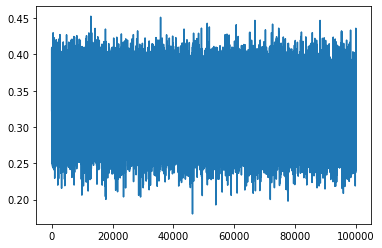

In [180]:
plt.plot(stepi, lossi)

In [181]:
print(f'loss on training set is {evaluate(x_tr, y_tr, lookup):.4f}')

loss on training set is 2.0906


In [182]:
print(f'loss on valid set is {evaluate(x_va, y_va, lookup):.4f}')
print(f'loss on test set is {evaluate(x_te, y_te, lookup):.4f}')

loss on valid set is 2.1411
loss on test set is 2.1276


In [167]:
sample_g = torch.Generator().manual_seed(34568789)

# Generate new name from the trained model
def sample(gen_num):

    for i in range(gen_num):
        gen_str = []
        context = [0] * window_size

        while True:
            emb_gen = lookup[torch.tensor(context)] # The size of the tensor (1, ws, emb_dim)
            
            # Generate (predict) by forwarding to the network with trained parameters
            h_preact = emb_gen.view(1, -1) @ W1 # The size of h_preact is (1, 200) 
            h_preact = bngain * (h_preact - bnmean_running) / bnstd_running + bnbias # Batch normalization
            h = torch.tanh(h_preact)
            logits = h @ W2 + b2

            # An array of probability for each char in prediction
            probs = F.softmax(logits, dim=1) 

            # Get the idx with greatest probability to be the next char
            idx = torch.multinomial(probs, num_samples=1, generator=sample_g).item()
            
            if idx != 0:
                context = context[1:] + [idx]
                gen_str.append(itos[idx])
            else:
                break
        
        # Print each name
        print(''.join(gen_str))

In [168]:
sample(20)

kriston
kess
ohalen
asheksymica
tanah
emmali
milaniah
keam
sazali
ver
quin
staliga
ezemier
mamee
ruq
sareyah
ana
fah
aryah
clary
